<font size="7">Image caption Generator using CNN and LSTM</font>

<font size="5">Group: HAT</font>

<font size="5">Instructor: Dr. Lê Thành Sách</font>

| Name            | ID |
| --------------- | --- |
| Nguyễn Thiên Ân | 2270710 |
| Huỳnh Nhữ Hùng  | 2270712 |
| Nguyễn Thanh Khải Tâm | 2270163 |

The target of this project is to utilize CNN and LSTM models to generate captions for images. The dataset used to train and test the model is FLickr3k.

#Import libraries

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import re

import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add, Conv2D

#Download dataset from Kaggle


##Install Gdown for downloading files stored in Google drive

In [3]:
!pip install gdown

##Prepare the Kaggle folder and API

In [4]:
# We need to place file kaggle.json in root to use kaggle API to download dataset
!mkdir ~/.kaggle
!gdown 1hOaGMilJuZmHpgNy9QXOei6zdgM-ONx6
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1hOaGMilJuZmHpgNy9QXOei6zdgM-ONx6
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 288kB/s]


##Download and unzip the dataset

In [5]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [01:40<00:00, 135MB/s]
100% 8.16G/8.16G [01:40<00:00, 87.5MB/s]


In [6]:
!unzip /content/flickr-image-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: /content/dataset/flickr30k_images/flickr30k_images/flickr30

In [7]:
dataset_image_folder_link = "dataset/flickr30k_images/flickr30k_images/"
dataset_csv_link = "dataset/flickr30k_images/results.csv"

#Dataset and Model overview


##Dataset overview

Flickr is an image hosting and video hosting service and is a great way for amateur and professional photographers to host high-resolution photos. As of June 2015, Flickr had more than 3.5 million new images upload daily. Flickr images come from a wide variety of sources such as the web, mobile devices, home computer, or whatever software that can be used to manage images content. Flickr not only store the images, but also the metadata that comes with them. Notes, tags, comments, etc. are very informative ways for a user to describe the images they are storing.

The Flickr image dataset has become a standard benchmark for sentence-based image description. It contains images from the Flickr website along with their descriptive captions. It also comes in different sizes. In our study, we are using the Flickr30k dataset which consists of 30,000 images paired with more than 158,000 captions.

In [8]:
df = pd.read_csv(filepath_or_buffer= dataset_csv_link, sep='|', skipinitialspace=True)
df

image_name comment_number  \
0       1000092795.jpg              0   
1       1000092795.jpg              1   
2       1000092795.jpg              2   
3       1000092795.jpg              3   
4       1000092795.jpg              4   
...                ...            ...   
158910   998845445.jpg              0   
158911   998845445.jpg              1   
158912   998845445.jpg              2   
158913   998845445.jpg              3   
158914   998845445.jpg              4   

                                                  comment  
0       Two young guys with shaggy hair look at their ...  
1       Two young , White males are outside near many ...  
2        Two men in green shirts are standing in a yard .  
3            A man in a blue shirt standing in a garden .  
4                 Two friends enjoy time spent together .  
...                                                   ...  
158910  A man in shorts and a Hawaiian shirt leans ove...  
158911  A young man hanging over the side of a boat , ...  
158912  A man is leaning off of the side of a blue and...  
158913  A man riding a small boat in a harbor , with f...  
158914  A man on a moored blue and white boat with hil...  

[158915 rows x 3 columns]

In [ ]:
df.describe()

image_name comment_number                         comment
count           158915         158915                          158914
unique           31783              6                          158438
top     1000092795.jpg              0  Two dogs playing in the snow .
freq                 5          31783                               7

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   comment_number  158915 non-null  object
 2   comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


As seen from the dataframe and description from the source, we can identify the meaning of the columns as:
*   **image_name**: The file name of the image.
*   **comment_number**: The index of the captions associating with each image. Each image should have exactly 5 captionss.
*   **comment**: The content of the caption.



In [ ]:
df.comment_number.value_counts()

0                                    31783
1                                    31783
2                                    31783
3                                    31783
4                                    31782
4   A dog runs across the grass .        1
Name: comment_number, dtype: int64

###Fix the wrongly formatted data

In [9]:
wrong_data = df.comment_number.value_counts().index[-1]
print(df[df.comment_number == wrong_data])

           image_name                     comment_number comment
19999  2199200615.jpg  4   A dog runs across the grass .     NaN


There are values that are not a number in the **comment_number** column due to the missing separtor from the dataset source. Since it's only a problem of missing separator, and we know what the columns' meaning are, we can fix this manually with a string split.

In [10]:
comment_number_list = df.comment_number.tolist()
for idx, value in enumerate(comment_number_list):
  splited = re.split('\s+', value, 1)
  if len(splited) == 2:
    print("Row before:", df.iloc[idx])
    df.iloc[idx].comment_number = splited[0]
    df.iloc[idx].comment = splited[1]
    print("\nRow after:", df.iloc[idx])

df.comment_number.value_counts()

Row before: image_name                           2199200615.jpg
comment_number    4   A dog runs across the grass .
comment                                         NaN
Name: 19999, dtype: object

Row after: image_name                       2199200615.jpg
comment_number                                4
comment           A dog runs across the grass .
Name: 19999, dtype: object


0    31783
1    31783
2    31783
3    31783
4    31783
Name: comment_number, dtype: int64

###Show images and their comments
After fixing the errors in format, we can show the images with their corresponding comments

In [11]:
def show_image(image, title="Image samples", figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap="gray") if image.ndim == 2 else plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

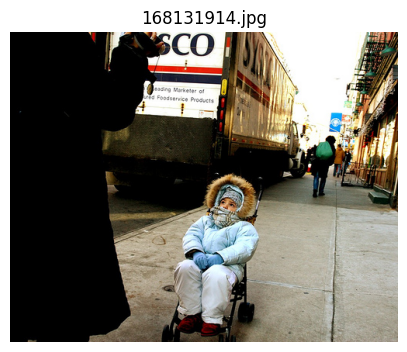

A young lady is being videotaped while she 's sitting in her stroller in front of a Sysco truck on the sidewalk .
A child is looking up at an adult while sitting in a stroller on a city sidewalk .
A baby in winter clothes is sitting on a stroller in the sidewalk .
A child in a blue jacket and red shoes is sitting in a stroller .
A child in a stroller is bundled up in a winter coat .


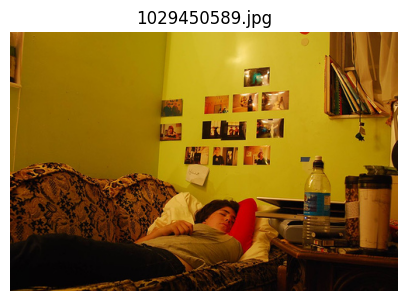

An adult wearing a gray shirt with red sleeves sleeping on a couch .
A woman in black pants napping on the couch .
A man sleeping in a green room on a couch .
The young woman is sleeping in her room .
A long-haired man sleeping on a couch


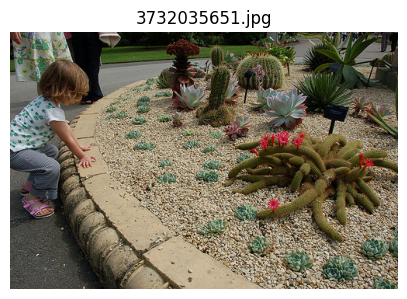

A toddler wearing a white shirt , blue jeans , and pink sandals bent over observing cacti and plants .
A small child looking at a cactus garden .
A little girl admiring outdoor plants .
Young girl looks at a cactus garden .
A child looks at a cactus garden .


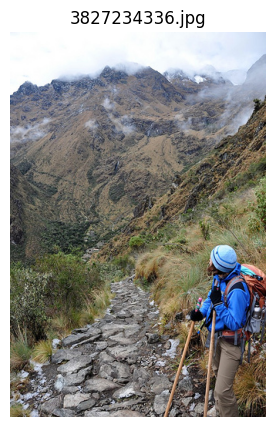

A hiker in a blue cap holding two walking sticks looks out over the path to the misty mountains in the distance .
A female mountain climber stands beside a mountain watching the steam rise from it .
A man is doing his adventure over the mountain .
An alpine enthusiast is looking down a trail .
Person in blue jacket hiking up mountain .


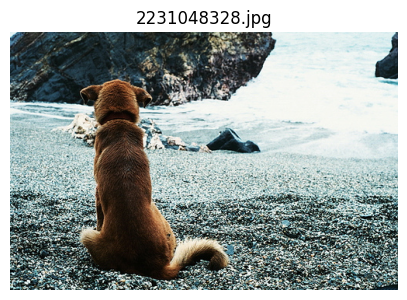

The back of a light brown dog sitting on sand looking out at a rock and the ocean .
A dog sits still while looking at large rocks .
Dog sitting looking out over a body of water .
A brown dog is sitting near a large rock .
The dog is waiting for his master .


In [ ]:
sample_image_names = df.image_name.sample(5)
df_samples = [df[df.image_name == image] for image in sample_image_names]
for image_name in sample_image_names:
  image_path = os.path.join(dataset_image_folder_link, image_name)
  if os.path.isfile(image_path):
    img = mpimg.imread(image_path)
    show_image(img, title=image_name)
    print("\n".join(df.comment[df.image_name == image_name].tolist()))
  else:
    print(f"The file {image_name} does not exist.")

In [43]:
# Filter the DataFrame to only include rows where the comment contains the string
def show_images_with_string(input_string, df):
  df_str = df[df['comment'].str.contains(input_string)]

  df_str = df_str.sample(5)

  print(df_str)

  print()

  # Plot the images
  fig, axs = plt.subplots(1, len(df_str), figsize=(20, 20))
  for i, row in enumerate(df_str.iterrows()):
      img = mpimg.imread(dataset_image_folder_link + row[1][0])
      axs[i].imshow(img)
      axs[i].axis('off')

  plt.show()

            image_name comment_number  \
58772   3173928684.jpg              2   
63195   3265162450.jpg              0   
67119   3354883962.jpg              4   
152834  7677138150.jpg              4   
15779   2064417101.jpg              4   

                                                  comment  
58772    Two large white dogs are fighting in the grass .  
63195   Two mostly white dogs are in the snow with a b...  
67119                            A dog runs in the snow .  
152834  A guys in a big jacket being attacked by a dog...  
15779                   three dogs run across the track .  



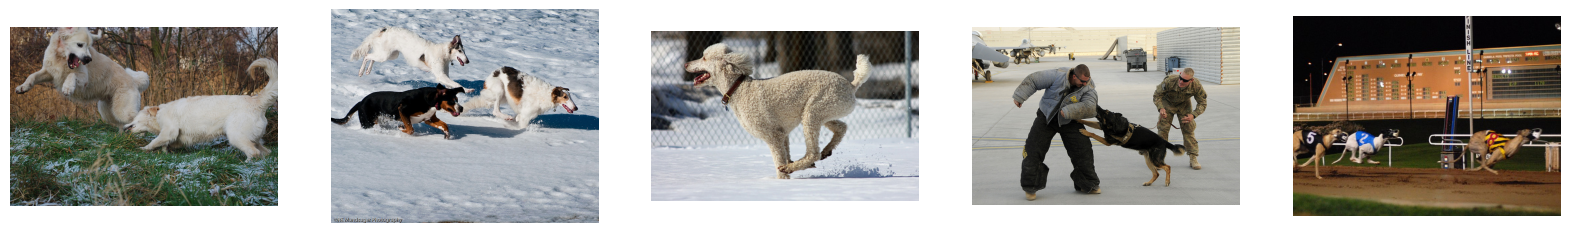

In [44]:
show_images_with_string("dog", df)

            image_name comment_number  \
111835  4700423961.jpg              0   
103953  4553449352.jpg              3   
114519  4742019207.jpg              4   
121459  4852829439.jpg              4   
54664   3072938154.jpg              4   

                                                  comment  
111835  A man hangs from a horizontal pole , jutted fr...  
103953  A man wearing a hat plays guitar for a group o...  
114519         A man in a blue tank top washes his face .  
121459              A man is waiting to place his order .  
54664                          A man is driving a train .  



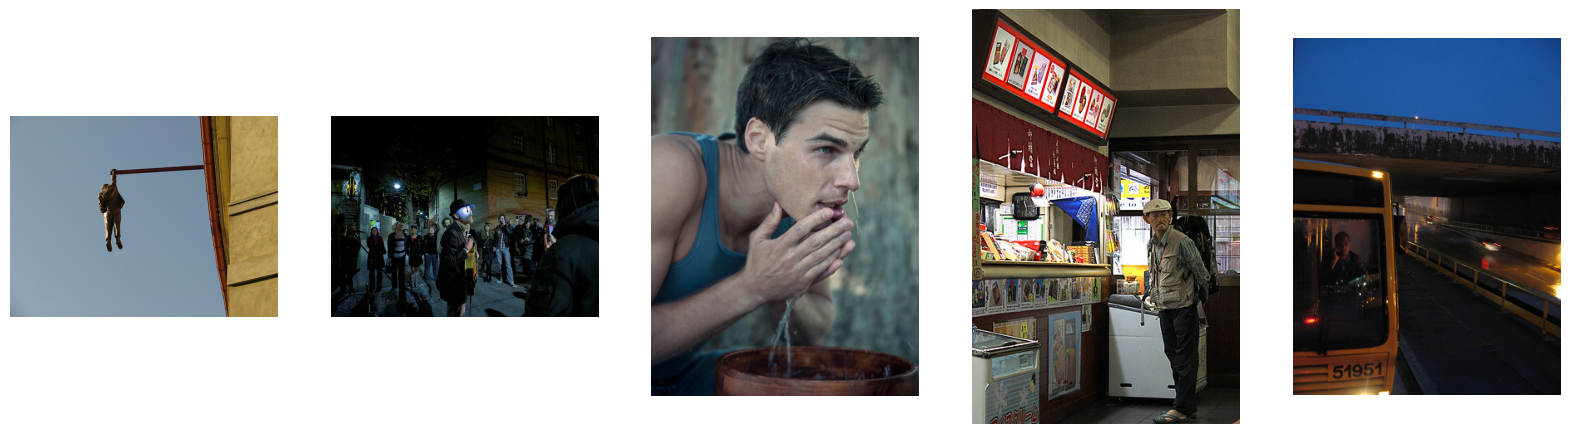

In [46]:
show_images_with_string(" man", df)

In [12]:
df_len_cap = df.comment.apply(len)
df_len_cap

0          83
1          54
2          48
3          44
4          39
         ... 
158910    117
158911    105
158912     89
158913     82
158914     77
Name: comment, Length: 158915, dtype: int64

Visualizing the caption length and word frequency.

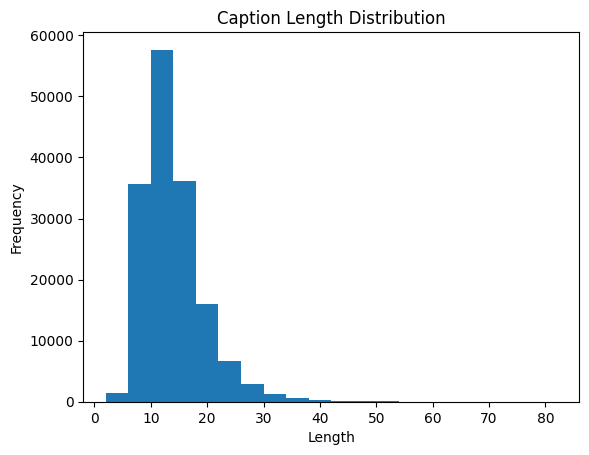

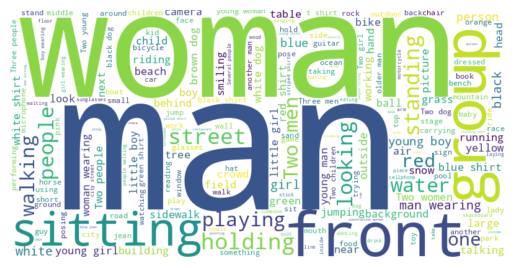

In [15]:
from wordcloud import WordCloud
from collections import Counter
import nltk

# Assuming captions is a list of caption strings
captions = df.comment.tolist()

# Calculate caption lengths
caption_lengths = [len(caption.split()) for caption in captions]
plt.hist(caption_lengths, bins=20)
plt.title('Caption Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Word frequency analysis
all_words = ' '.join(captions).split()
word_freq = Counter(all_words)
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count'])
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(captions))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Model overview

###VGG16

####Introduction
VGG 16 was proposed by Karen Simonyan and Andrew Zisserman of the Visual Geometry Group Lab of Oxford University (hence the name VGG) in 2014 in the paper “VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION”. This model has won the first and second prizes in object detection and image classification in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) challenge that year.

VGG16 is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the popular algorithms for image classification and is easy to use with transfer learning.

VGG has many configurations such as 11, 13, 16, 19 layers. It can be seen in the picture below:

![VGG configurations](https://drive.google.com/uc?export=view&id=1yvo4UnQVBQs9nzqE6k5Khijp0EMdz8JL "VGG configurations")

####Architecture
VGG16 consists of 13 convolutional layers, 5 max pooling layers, and 3 dense layers which sums up to 21 layers. The 16 in VGG16 represents the 16 layers that have weights. Here are some characteristics of the layers used in VGG16:

* **Input**: It takes input tensor size (224, 244, 3) which is an 224x224 RGB image.

* **Convolutional layers**: A unique thing about VGG16 is that instead of having a large number of hyper-parameters the creators focused on having convolution layers of 3x3 filter with stride 1 and always used the same padding and maxpool layer of 2x2 filter of stride 2. The small filters help reducing the parameters per layer and allow the network to expand deeper.

* **Activation**: Uses Rectified Linear Unit (ReLU). It allows the model to train easier and often achieve good performance by helping the model to overcome the gradient vanishing problem.

* **Pooling layers**: Uses MaxPooling2D which helps reduce computational load.
* **Dense layers**: Utilizes three fully connected layers. The first two has 4096 channels while the last one is a softmax with 1000 channels for 1000 objects it detects.

|  | |
|---|---|
| ![VGG16 architecture 1](https://datagen.tech/wp-content/uploads/2022/11/image2-1.png "VGG16 architecture") | ![VGG architecture 2](https://drive.google.com/uc?export=view&id=1CRQ0Xzbl6fE6yWaUjDdbdeH74_qDnvQr "VGG16 architecture") |

In [ ]:
model = VGG16()
model.summary(show_trainable=True)

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     Y          
                                                                       

###Long Short Term Memory (LSTM)

####Introduction
Recurrent Neural Network (RNN) is a popular type of network used in deep learning. It differs from other feed-forward networks such as CNN due to the feed-backward connections where the flow of information occurs between neurons of the same layer or from one layer to another.

Feedback connections allow the network to perform tasks that require memory. This is because the network keeps information about its previous status. More specifically, the network at the time t transmits to itself the information to be used at the moment t+1 and combine with the external inputs received in t+1. In other words, the behavior of the network is influenced by the input it receives at a given instant, and by what happened to the network at the previous instant.

Long Short-Term Memory (LSTM) is a recurrent neural network architecture designed by Sepp Hochreiter and Jürgen Schmidhuber in 1997.

####Architecture
![LSTM Architecture](https://drive.google.com/uc?export=view&id=15vHOJbEDCEUY6xw4j_zzYO_NAuNF_2mM "LSTM architecture")

The LSTM architecture has a LSTM unit (memory unit). It has 4 feed forward neural networks. Each of these networks has an input and an output layer. Those 2 layers are fully connected to each other inside each network. As a result, an LSTM unit has 4 fully connected layers.

The four layers mentioned above are usually called **Forget gate**, **Input gate**, **Candidate memory**, and **Output gate**. The three "gates" are information selectors. A selector vector is created to be multiplied, element by element, by another vector of the same size. This means that a position where the selector vector has a value equal to zero completely eliminates the information included in the same position in the other vector. A position where the selector vector has a value equal to one leaves unchanged the information included in the same position in the other vector. Sigmoid activation functions are used in all three gates as they provide an output from 0 to 1.

Here are some more details of the layers' characteristics:
* **Forget gate**: At time t, the LSTM unit receives an input vector X(t), hidden state (H(t-1)) and cell state (C(t-1)). t-1 indicates the time before t. The gate will then decides what information to keep from C(t-1) (based on H(t-1) and X(t)) which results in the selector vector. The selector vector is then multiplied element wise with C(t-1) which generates a matrix that contains only 1s and 0s. A 1 means to completely keep the information and 0 is get rid of it.
* **Input gate and Candidate memory**: These two networks are independent from each other and will receive inputs from X(t) and H(t-1) which are concatenated together.

#Implementation

##Model configuration
Since we do not need the classification of 1000 objects from the final softmax layer but only the extract feature results, the original final layer was removed.

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##Extract the image features

In [ ]:
# extract features from image
features = {}

for img_name in tqdm(os.listdir(dataset_image_folder_link)):
  # Load the image from file
  img_path = dataset_image_folder_link + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  # Convert image pixels to numpy array
  image = img_to_array(image)
  # Reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # Preprocess image for vgg
  image = preprocess_input(image)
  # Extract features
  feature = model.predict(image, verbose=0)
  # Get image ID
  image_id = img_name.split('.')[0]
  # Store feature
  features[image_id] = feature

  0%|          | 0/31785 [00:00<?, ?it/s]

IsADirectoryError: ignored

Dictionary 'features' is created and will be loaded with the extracted features of image data

load_img(img_path, target_size=(224, 224)): Custom dimension to resize the image when loaded to the array

image.reshape((1, image.shape[0], image.shape[1], image.shape[2])): Reshaping the image data to preprocess in a RGB type image.

model.predict(image, verbose=0): Extraction of features from the image

img_name.split('.')[0]: Split of the image name from the extension to load only the image name.

In [ ]:
# Store features in pickle
pickle.dump(features, open('features.pkl'), 'wb')

In [ ]:
# Load features from pickle
with open('features.pkl', 'rb') as f:
  features = pickle.load(f)

##Preprocess the captions

In [ ]:
def preprocess(caption):
  caption = caption.lower()
  # Convert to lowercase
  caption = caption.lower()
  # Delete digits, special chars, etc.
  caption = caption.replace('[^A-Za-z]', '')
  # Delete additional spaces
  caption = caption.replace('\s+', ' ')
  # Add start and end tags to the caption
  caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
  return caption

In [ ]:
df['comment'] = df['comment'].apply(preprocess)
df

##Text data processing

In [ ]:
all_captions = df['comment'].tolist()
all_captions

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

In [ ]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

##Train test split

In [ ]:
image_id_list = df.image_name.tolist()
image_id_list

In [ ]:
split_train = int(len(image_id_list) * 0.50)
split_test = int(len(image_id_list) * 0.55)
split_valid = int(len(image_id_list) * 0.60)
train = image_id_list[:split_train]
test = image_id[split_train:split_test]
valid = image_id[split_test:split_valid]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
I
# plot the model
plot_model(model, show_shapes=True)

shape=(4096,) - output length of the features from the VGG model

Dense - single dimension linear layer array

Dropout() - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

model.compile() - compilation of the model

loss=’sparse_categorical_crossentropy’ - loss function for category outputs

optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

Model plot shows the concatenation of the inputs and outputs into a single layer

Feature extraction of image was already done using VGG, no CNN model was needed in this step.

Train Model

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

steps = len(train) // batch_size - back propagation and fetch the next data

Loss decreases gradually over the iterations

Increase the no. of epochs for better results

Assign the no. of epochs and batch size accordingly for quicker results

In [ ]:
subject = 'img caption'
save_path = ''

# Save model
save_id = str(f'{subject}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')